# Novelty

In [1]:
from ipynb.fs.full.koselleck import *

[Koselleck] (16:31:54) Alles bereit (+0.0s)


In [2]:
def make_foote(quart=FOOTE_W):
    tophalf = [-1] * quart + [1] * quart
    bottomhalf = [1] * quart + [-1] * quart
    foote = list()
    for i in range(quart):
        foote.append(tophalf)
    for i in range(quart):
        foote.append(bottomhalf)
    foote = np.array(foote)
    return foote

def foote_novelty(distdf, foote_size=5):
    foote=make_foote(foote_size)
    distmat = distdf.values if type(distdf)==pd.DataFrame else distdf
    
    axis1, axis2 = distmat.shape
    assert axis1 == axis2
    distsize = axis1
    axis1, axis2 = foote.shape
    assert axis1 == axis2
    halfwidth = axis1 / 2
    novelties = []
    for i in range(distsize):
        start = int(i - halfwidth)
        end = int(i + halfwidth)
        if start < 0 or end > (distsize - 1):
            novelties.append(0)
        else:
            novelties.append(np.sum(foote * distmat[start: end, start: end]))
    return novelties

def getyears():
    years=list(d.columns)
    return years


def diagonal_permute(d):
    newmat = np.zeros(d.shape)
    
    # We create one randomly-permuted list of integers called "translate"
    # that is going to be used for the whole matrix.
    
    xlen,ylen=d.shape
    translate = [i for i in range(xlen)]
    random.shuffle(translate)
    
    # Because distances matrices are symmetrical, we're going to be doing
    # two diagonals at once each time. We only need one set of values
    # (because symmetrical) but we need two sets of indices in the original
    # matrix so we know where to put the values back when we're done permuting
    # them.
    
    for i in range(0, xlen):
        indices1 = []
        indices2 = []
        values = []
        for x in range(xlen):
            y1 = x + i
            y2 = x - i
            if y1 >= 0 and y1 < ylen:
                values.append(d[x, y1])
                indices1.append((x, y1))
            if y2 >= 0 and y2 < ylen:
                indices2.append((x, y2))
        
        # Okay, for each diagonal, we permute the values.
        # We'll store the permuted values in newvalues.
        # We also check to see how many values we have,
        # so we can randomly select values if needed.
        
        newvalues = []
        lenvals = len(values)
        vallist = [i for i in range(lenvals)]
        
        for indexes, value in zip(indices1, values):
            x, y = indexes
            
            xposition = translate[x]
            yposition = translate[y]
            
            # We're going to key the randomization to the x, y
            # values for each point, insofar as that's possible.
            # Doing this will ensure that specific horizontal and
            # vertical lines preserve the dependence relations in
            # the original matrix.
            
            # But the way we're doing this is to use the permuted
            # x (or y) values to select an index in our list of
            # values in the present diagonal, and that's only possible
            # if the list is long enough to permit it. So we check:
            
            if xposition < 0 and yposition < 0:
                position = random.choice(vallist)
            elif xposition >= lenvals and yposition >= lenvals:
                position = random.choice(vallist)
            elif xposition < 0:
                position = yposition
            elif yposition < 0:
                position = xposition
            elif xposition >= lenvals:
                position = yposition
            elif yposition >= lenvals:
                position = xposition
            else:
                position = random.choice([xposition, yposition])
                # If either x or y could be used as an index, we
                # select randomly.
            
            # Whatever index was chosen, we use it to select a value
            # from our diagonal. 
            
            newvalues.append(values[position])
            
        values = newvalues
        
        # Now we lay down (both versions of) the diagonal in the
        # new matrix.
        
        for idxtuple1, idxtuple2, value in zip(indices1, indices2, values):
            x, y = idxtuple1
            newmat[x, y] = value
            x, y = idxtuple2
            newmat[x, y] = value
    
    return newmat

def zeroless(sequence):
    newseq = []
    for element in sequence:
        if element > 0.01:
            newseq.append(element)
    return newseq

def permute_test(distmatrix, foote_size=FOOTE_W, num_runs=100):
    actual_novelties = foote_novelty(distmatrix, foote_size)    
    permuted_peaks = []
    permuted_troughs = []
    xlen,ylen=distmatrix.shape
    for i in range(num_runs):
        randdist = diagonal_permute(distmatrix)
        nov = foote_novelty(randdist, foote_size)
        nov = zeroless(nov)
        permuted_peaks.append(np.max(nov))
        permuted_troughs.append(np.min(nov))
    permuted_peaks.sort(reverse = True)
    permuted_troughs.sort(reverse = True)
    significance_peak = np.ones(len(actual_novelties))
    significance_trough = np.ones(len(actual_novelties))
    for idx, novelty in enumerate(actual_novelties):
        ptop=[i for i,x in enumerate(permuted_peaks) if x and x < novelty]
        ptop=ptop[0]/num_runs if ptop else 1
        pbot=[i for i,x in enumerate(permuted_troughs) if x and x > novelty]
        pbot=pbot[-1]/num_runs if pbot else 1
        significance_peak[idx]=ptop
        significance_trough[idx]=pbot
        
        
    
    return actual_novelties, significance_peak, significance_trough

def colored_segments(novelties, significance, yrwidth=1,min_year=1700):
    x = []
    y = []
    t = []
    idx = 0
    for nov, sig in zip(novelties, significance):
        if nov > 1:
            x.append((idx*yrwidth) + min_year)
            y.append(nov)
            t.append(sig)
        idx += 1
        
    x = np.array(x)
    y = np.array(y)
    t = np.array(t)
    
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(t)
    
    return lc, x, y
    
    
def test_novelty(distdf, foote_sizes=None, num_runs=100):
    if not foote_sizes: foote_sizes=range(FOOTE_W-3, FOOTE_W+2)
    dq=distdf.fillna(0).values
    o=[]
    for fs in foote_sizes:
        try:
            novelties, significance_peak, significance_trough = permute_test(dq, foote_size=fs, num_runs=num_runs)
        except ValueError as e:
#             print('!!',e,'!!')
#             print(distdf)
            continue
        for year,nov,sigp,sigt in zip(distdf.columns, novelties, significance_peak, significance_trough):
            odx={
                'period':year,
                'foote_novelty':nov,
                'foote_size':fs,
                'p_peak':sigp,
                'p_trough':sigt,
            }
            o.append(odx)
    return pd.DataFrame(o)


## Novelty

In [3]:
def get_words_with_lnm():
    with get_veclib('lnm') as vl:
        return [x.split(',')[0] for x in vl.keys()]

In [4]:
def nov_word(word,progress=False,cache=True,force=False,cache_only=False,
             interpolate=False,normalize=False,add_missing_periods=True,**kwargs):
    odf=None
    if cache and not force:
        with get_veclib('nov') as vl:
            odf=vl.get(word)
    
    if odf is None or not len(odf):
        odf=test_novelty(get_historical_semantic_distance_matrix(
                word,
                interpolate=interpolate,
                normalize=normalize,
                progress=progress,
                add_missing_periods=add_missing_periods
#                 force=force
            ),
            **kwargs
        )
        if odf is not None and len(odf):
            odf=odf.query('foote_novelty!=0').assign(word=word)
        if cache:
            with get_veclib('nov',autocommit=True) as vl:
                vl[word]=odf
    return pd.DataFrame() if (odf is None or cache_only or not len(odf)) else odf.set_index(['word','period'])

In [5]:
# for w in ['ancestor','station','culture','demand','slave','time']:
#     printm('### '+w)
#     printm('#### No interpolation')
#     display(round(nov_word(w,force=True,interpolate=False,normalize=False,add_missing_periods=False)[['foote_novelty','foote_size']].describe(),2))
#     printm('#### Interpolation')
#     display(round(nov_word(w,force=True,interpolate=True,normalize=False,add_missing_periods=False)[['foote_novelty','foote_size']].describe(),2))
#     printm('----')

## Scaling up

In [6]:
def _nov_(objd): return nov_word(**objd)

def nov(
        word_or_words,
        progress=True,
        cache=True,
        force=False,
        num_proc=1,
        cache_only=False,
        ):
    words=tokenize_fast(word_or_words) if type(word_or_words)==str else list(word_or_words)
    
    objs=[
        dict(
            word=word,
            progress=False if len(words)>1 else progress,
            cache=cache,
            force=force,
            cache_only=cache_only,
        ) for word in words
    ]
    o=pmap(
        _nov_,
        objs,
        num_proc=num_proc if len(words)>1 else 1,
        progress=progress if len(words)>1 else False,
        desc='Measuring novelty across words',
    )
    return pd.concat(o) if len(o) else pd.DataFrame()


In [7]:
# nov('virtue,vice',force=True)

In [8]:
def get_novelty(words,min_foote_size=4,max_foote_size=6,**nov_attrs):
    words=tokenize_fast(words) if type(words)==str else words
    if DFALLNOV is not None:
        odf=DFALLNOV[DFALLNOV.word.isin(set(words))]
    else:
        odf=nov(words,force=False,**nov_attrs).query(f'{min_foote_size}<=foote_size<={max_foote_size}')
        odf=pd.concat(
            grp.assign(foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std())
            for i,grp in odf.groupby('foote_size')
        )
        odf=odf.reset_index()
        odf['period_str']=odf['period']
        odf['period']=odf['period'].apply(lambda x: int(x[:4]))
        odf['is_signif']=odf['p_peak']<=0.05
    return odf

In [9]:
get_novelty('station')

,word,period,foote_novelty,foote_size,p_peak,p_trough,foote_novelty_z,period_str,is_signif
0,station,1740,191.111111,4,1.00,0.30,-0.773612,1740-1745,False
1,station,1745,157.460317,4,1.00,0.43,-0.829297,1745-1750,False
2,station,1750,98.095238,4,1.00,0.71,-0.927535,1750-1755,False
3,station,1755,343.492063,4,1.00,0.03,-0.521451,1755-1760,False
4,station,1760,455.873016,4,1.00,1.00,-0.335483,1760-1765,False
...,...,...,...,...,...,...,...,...,...
73,station,1845,4806.031746,6,0.00,1.00,1.970379,1845-1850,True
74,station,1850,5552.698413,6,0.00,1.00,2.473459,1850-1855,True
75,station,1855,4178.730159,6,0.00,1.00,1.547723,1855-1860,True
76,station,1860,3474.603175,6,0.01,1.00,1.073305,1860-1865,True


## All novelty scores

In [10]:
def get_all_novelty_scores(by_foote_size=False, min_foote_size=4, max_foote_size=6, min_periods=20, cache=True):
    global DFALLNOV
    if DFALLNOV is not None and len(DFALLNOV):
        allnov=odf=DFALLNOV
    elif cache and os.path.exists(FN_NOV_CACHE):
        odf=read_df(FN_NOV_CACHE)
    else:
        words_done=get_words_with_lnm()
        odf=get_novelty(words_done)
        if cache: odf.to_pickle(FN_NOV_CACHE)
        DFALLNOV=odf
    
    # filter
    odf=odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    if min_periods:
        odf=odf[odf.foote_size==max_foote_size].groupby('word').filter(lambda grp: len(grp)>=min_periods)
        
    if not by_foote_size:
        odf=odf.groupby(['word','period']).mean().drop('foote_size',1).reset_index()
    else:
        odf['foote_size']=odf.foote_size.apply(int)

    return odf
        


In [11]:
allnov=get_all_novelty_scores()
allnov

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z,is_signif
0,abbe,1750,2546.629213,0.00,1.0,2.140611,True
1,abbe,1755,2277.528090,0.06,1.0,1.800906,False
2,abbe,1760,1787.640449,0.59,1.0,1.182487,False
3,abbe,1765,2000.000000,0.31,1.0,1.450563,False
4,abbe,1770,1330.337079,0.99,1.0,0.605201,False
...,...,...,...,...,...,...,...
136281,zealous,1845,2303.236246,0.02,1.0,1.833359,True
136282,zealous,1850,2238.187702,0.04,1.0,1.751244,True
136283,zealous,1855,1910.355987,0.51,1.0,1.337399,False
136284,zealous,1860,1501.941748,1.00,1.0,0.821830,False


In [12]:
allnov.groupby('word').mean().sort_values('foote_novelty_z',ascending=False).head(25)

,period,foote_novelty,p_peak,p_trough,foote_novelty_z,is_signif
word,,,,,,
intelligence,1807.5,2565.396825,0.818750,0.757500,2.164303,0.125000
medicine,1807.5,2251.578384,0.648333,0.766667,1.768148,0.083333
special,1807.5,2240.830679,0.627083,0.875417,1.754580,0.250000
circuit,1810.0,2142.558243,0.760870,0.816087,1.630524,0.086957
distress,1807.5,2114.202438,0.820417,0.839583,1.594729,0.125000
quality,1807.5,2074.325397,0.736667,0.677917,1.544389,0.125000
minute,1807.5,2020.839958,0.795000,0.731667,1.476871,0.125000
concerns,1807.5,2000.039683,0.734167,0.765417,1.450613,0.208333
lines,1807.5,1998.195329,0.650417,0.778750,1.448285,0.208333


In [13]:
# get_all_novelty_scores(
#     by_foote_size=True,min_foote_size=4,max_foote_size=6,min_periods=20
# ).groupby('word').size().sort_values()

In [23]:
# allnov.loc['special']

## Significant words

In [24]:
def get_signif_novelty_scores(p_peak=0.05,min_peaks=1):
    odf=get_all_novelty_scores().query(f'p_peak<{p_peak}')
    odf=pd.concat(
        grp.assign(
            word_num_peaks=len(grp[grp.p_peak<p_peak])
        ) for i,grp in odf.groupby('word')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    return odf.sort_values('foote_novelty_z',ascending=False)#.reset_index()

In [27]:
dfsign=get_signif_novelty_scores()
dfsign

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z,is_signif,word_num_peaks
48453,flat,1865,5857.735247,0.00,1.0,6.320449,True,2
19886,choir,1855,5615.161290,0.00,1.0,6.014231,True,4
116690,station,1850,5552.698413,0.00,1.0,5.935380,True,5
21221,cloth,1830,5315.974441,0.00,1.0,5.636547,True,4
115817,sport,1830,5277.288136,0.00,1.0,5.587710,True,4
...,...,...,...,...,...,...,...,...
35254,disapprobation,1810,526.315789,0.01,1.0,-0.409770,True,1
130146,vehemence,1835,515.384615,0.03,1.0,-0.423569,True,1
110685,serpents,1790,488.888889,0.02,1.0,-0.457017,True,1
71161,licentiousness,1820,460.869565,0.03,1.0,-0.492387,True,1


In [29]:
dfsignw=dfsign.groupby('word').mean()
dfsignw

,period,foote_novelty,p_peak,p_trough,foote_novelty_z,is_signif,word_num_peaks
word,,,,,,,
abbe,1772.5,2958.426966,0.000000,1.0,2.660452,True,2.0
abbot,1817.5,2393.620415,0.020000,1.0,1.947457,True,4.0
ability,1787.5,2192.993631,0.025000,1.0,1.694192,True,2.0
abode,1825.0,2851.738437,0.004000,1.0,2.525771,True,5.0
abolition,1820.0,2914.880952,0.006667,1.0,2.605481,True,3.0
...,...,...,...,...,...,...,...
young,1750.0,2073.015873,0.000000,1.0,1.542736,True,1.0
youthful,1822.5,2234.777585,0.008333,1.0,1.746939,True,6.0
youths,1810.0,2999.443285,0.000000,1.0,2.712230,True,3.0


In [36]:
dfchangepoints=get_signif_novelty_scores(p_peak=.05, min_peaks=1).drop_duplicates('word',keep='first').set_index('word')
dfchangepoints=dfchangepoints.join(dfsignw,rsuffix='_avg_sign')
dfchangepoints=dfchangepoints.join(get_all_novelty_scores().groupby('word').mean(),rsuffix='_avg')
prefcols=['period','word_num_peaks']
dfchangepoints = dfchangepoints[prefcols + sorted([c for c in dfchangepoints.columns if c not in set(prefcols)])]
dfchangepoints = dfchangepoints.sort_values('period')
dfchangepoints

,period,word_num_peaks,foote_novelty,foote_novelty_avg,foote_novelty_avg_sign,foote_novelty_z,foote_novelty_z_avg,foote_novelty_z_avg_sign,is_signif,is_signif_avg,is_signif_avg_sign,p_peak,p_peak_avg,p_peak_avg_sign,p_trough,p_trough_avg,p_trough_avg_sign,period_avg,period_avg_sign,word_num_peaks_avg_sign
word,,,,,,,,,,,,,,,,,,,,
english,1750,1,2472.698413,1192.539683,2472.698413,2.047283,0.431250,2.047283,True,0.041667,True,0.01,0.817500,0.010000,1.0,0.833333,1.0,1807.5,1750.0,1.0
creditors,1750,1,2266.891892,905.137950,2266.891892,1.787479,0.068443,1.787479,True,0.041667,True,0.02,0.909167,0.020000,1.0,0.768333,1.0,1807.5,1750.0,1.0
throne,1750,1,2034.603175,1149.140212,2034.603175,1.494245,0.376464,1.494245,True,0.083333,True,0.00,0.895000,0.000000,1.0,0.677917,1.0,1807.5,1750.0,1.0
exalted,1750,2,2892.185008,1262.214248,2647.527911,2.576830,0.519205,2.267982,True,0.083333,True,0.00,0.841250,0.005000,1.0,0.655000,1.0,1807.5,1752.5,2.0
belly,1750,2,2890.099010,640.311174,2585.148515,2.574197,-0.265866,2.189237,True,0.095238,True,0.00,0.851429,0.000000,1.0,0.863333,1.0,1800.0,1752.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phrase,1865,1,2418.918919,1162.720329,2418.918919,1.979394,0.393607,1.979394,True,0.043478,True,0.00,0.834783,0.000000,1.0,0.593043,1.0,1810.0,1865.0,1.0
celebrity,1865,3,2432.380952,814.920635,2318.095238,1.996388,-0.045444,1.852117,True,0.190476,True,0.00,0.722857,0.003333,1.0,0.963810,1.0,1815.0,1860.0,3.0
accord,1865,1,2445.203252,904.390244,2445.203252,2.012574,0.067499,2.012574,True,0.041667,True,0.00,0.887083,0.000000,1.0,0.731667,1.0,1807.5,1865.0,1.0


In [48]:
topwords=dfchangepoints.sort_values(
    'foote_novelty_z_avg_sign',ascending=False
).query('word_num_peaks>2')
topwords

,period,word_num_peaks,foote_novelty,foote_novelty_avg,foote_novelty_avg_sign,foote_novelty_z,foote_novelty_z_avg,foote_novelty_z_avg_sign,is_signif,is_signif_avg,is_signif_avg_sign,p_peak,p_peak_avg,p_peak_avg_sign,p_trough,p_trough_avg,p_trough_avg_sign,period_avg,period_avg_sign,word_num_peaks_avg_sign
word,,,,,,,,,,,,,,,,,,,,
choir,1855,4,5615.161290,1744.946237,4416.854839,6.014231,1.128591,4.501526,True,0.166667,True,0.0,0.805000,0.000000,1.0,0.855417,1.0,1807.500000,1857.5,4.0
station,1850,5,5552.698413,1881.613757,4347.809524,5.935380,1.301116,4.414365,True,0.208333,True,0.0,0.728750,0.002000,1.0,0.815417,1.0,1807.500000,1850.0,5.0
intelligence,1825,3,4490.158730,2565.396825,4208.359788,4.594063,2.164303,4.238328,True,0.125000,True,0.0,0.818750,0.006667,1.0,0.757500,1.0,1807.500000,1825.0,3.0
assurance,1840,3,5051.923077,1372.008547,4165.705128,5.303217,0.657806,4.184482,True,0.125000,True,0.0,0.845000,0.000000,1.0,0.635833,1.0,1807.500000,1840.0,3.0
organ,1835,3,4971.278459,1578.892865,4129.246935,5.201413,0.918971,4.138459,True,0.130435,True,0.0,0.771304,0.000000,1.0,0.850870,1.0,1810.000000,1835.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cream,1855,3,1372.067039,160.847300,1250.279330,0.657880,-0.871126,0.504139,True,0.125000,True,0.0,0.812917,0.020000,1.0,0.953333,1.0,1807.500000,1855.0,3.0
steeple,1855,4,1303.296703,245.198280,1239.560440,0.571067,-0.764644,0.490608,True,0.173913,True,0.0,0.738261,0.020000,1.0,0.840435,1.0,1808.478261,1850.0,4.0
discernment,1790,5,1337.704918,221.475410,1196.721311,0.614502,-0.794591,0.436529,True,0.250000,True,0.0,0.747500,0.008000,1.0,0.995000,1.0,1797.500000,1790.0,5.0


In [49]:
topwords.head(25)

,period,word_num_peaks,foote_novelty,foote_novelty_avg,foote_novelty_avg_sign,foote_novelty_z,foote_novelty_z_avg,foote_novelty_z_avg_sign,is_signif,is_signif_avg,is_signif_avg_sign,p_peak,p_peak_avg,p_peak_avg_sign,p_trough,p_trough_avg,p_trough_avg_sign,period_avg,period_avg_sign,word_num_peaks_avg_sign
word,,,,,,,,,,,,,,,,,,,,
choir,1855,4,5615.161290,1744.946237,4416.854839,6.014231,1.128591,4.501526,True,0.166667,True,0.0,0.805000,0.000000,1.0,0.855417,1.0,1807.5,1857.5,4.0
station,1850,5,5552.698413,1881.613757,4347.809524,5.935380,1.301116,4.414365,True,0.208333,True,0.0,0.728750,0.002000,1.0,0.815417,1.0,1807.5,1850.0,5.0
intelligence,1825,3,4490.158730,2565.396825,4208.359788,4.594063,2.164303,4.238328,True,0.125000,True,0.0,0.818750,0.006667,1.0,0.757500,1.0,1807.5,1825.0,3.0
assurance,1840,3,5051.923077,1372.008547,4165.705128,5.303217,0.657806,4.184482,True,0.125000,True,0.0,0.845000,0.000000,1.0,0.635833,1.0,1807.5,1840.0,3.0
organ,1835,3,4971.278459,1578.892865,4129.246935,5.201413,0.918971,4.138459,True,0.130435,True,0.0,0.771304,0.000000,1.0,0.850870,1.0,1810.0,1835.0,3.0
compass,1865,3,4928.980892,1346.669321,4018.683652,5.148018,0.625819,3.998887,True,0.125000,True,0.0,0.865833,0.006667,1.0,0.516250,1.0,1807.5,1860.0,3.0
distress,1810,3,4303.020668,2114.202438,3996.926338,4.357825,1.594729,3.971421,True,0.125000,True,0.0,0.820417,0.000000,1.0,0.839583,1.0,1807.5,1810.0,3.0
sport,1830,4,5277.288136,1551.363301,3974.745763,5.587710,0.884218,3.943421,True,0.173913,True,0.0,0.799565,0.005000,1.0,0.741739,1.0,1810.0,1827.5,4.0
main,1815,3,4567.567568,1541.719661,3971.701113,4.691781,0.872044,3.939578,True,0.125000,True,0.0,0.806667,0.000000,1.0,0.595833,1.0,1807.5,1815.0,3.0


In [17]:
def get_signif_novelty_words(p_peak=0.05,min_peaks=1):
    df=get_all_novelty_scores()
    dfsign=get_signif_novelty_scores(p_peak=p_peak,min_peaks=min_peaks)
    signwset=set(dfsign.word)
    o=[
        w for w in 
        df.groupby('word').mean().sort_values('foote_novelty',ascending=False).index
        if w in signwset
    ]
    print('# all words',len(set(df.word)))
    print('# signif words',len(set(dfsign.word)))
    return o

In [18]:
sign_words = get_signif_novelty_words(p_peak=0.05)
len(sign_words), random.sample(sign_words,10)

[Koselleck] (16:32:06) # all words 5759 (+12.3s)
[Koselleck] (16:32:06) # signif words 3343 (+0.0s)


(3343,
 ['theatres',
  'armed',
  'consummate',
  'atrocious',
  'ink',
  'monuments',
  'engagement',
  'skill',
  'aspiring',
  'foul'])

## Plotting

### Plotting all significant words' novelties

In [19]:
def plot_novelty_by_foote_size(p_peak=0.01,min_peaks=1,rolling=2, ymin=-1, nudge_x=1, labsize=6,words={}):
    df=get_all_novelty_scores(by_foote_size=True, min_foote_size=4, max_foote_size=6)
    if not words: words=get_signif_novelty_words(p_peak=p_peak,min_peaks=min_peaks)
#     words={w for w in words if not 's' in w and not 'f' in w}
    print('# words used:',len(words))
    if words: df=df[df.word.isin(words)]
    figdf=pd.DataFrame([
        {
            'foote_size':fs,
            'period':period,
            'num_peaks':len(grp.query(f'p_peak<{p_peak}')),
            'avg_nov_signif':grp.query(f'p_peak<{p_peak}').foote_novelty_z.mean(),
            'avg_nov':grp.foote_novelty_z.mean(),
        } for ((fs,period),grp) in df.groupby([
            'foote_size','period'
        ])
    ])
    for ycol in ['avg_nov','avg_nov_signif']:
        figdf[ycol]=figdf[ycol].rolling(rolling,min_periods=1).mean()
    
    fig=start_fig(
        figdf,
        x='period',
        y='num_peaks',
#         size='num_peaks',
        color='factor(foote_size)',
#         linetype='factor(foote_size)',
    )
    fig+=p9.geom_line()
    fig+=p9.geom_point(p9.aes(shape='factor(foote_size)'))
    
    fig+=p9.scale_color_gray(start=.8, end=.2)
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    return fig

[Koselleck] (16:32:09) # all words 5759 (+3.2s)
[Koselleck] (16:32:09) # signif words 2217 (+0.0s)
[Koselleck] (16:32:09) # words used: 2217 (+0.0s)


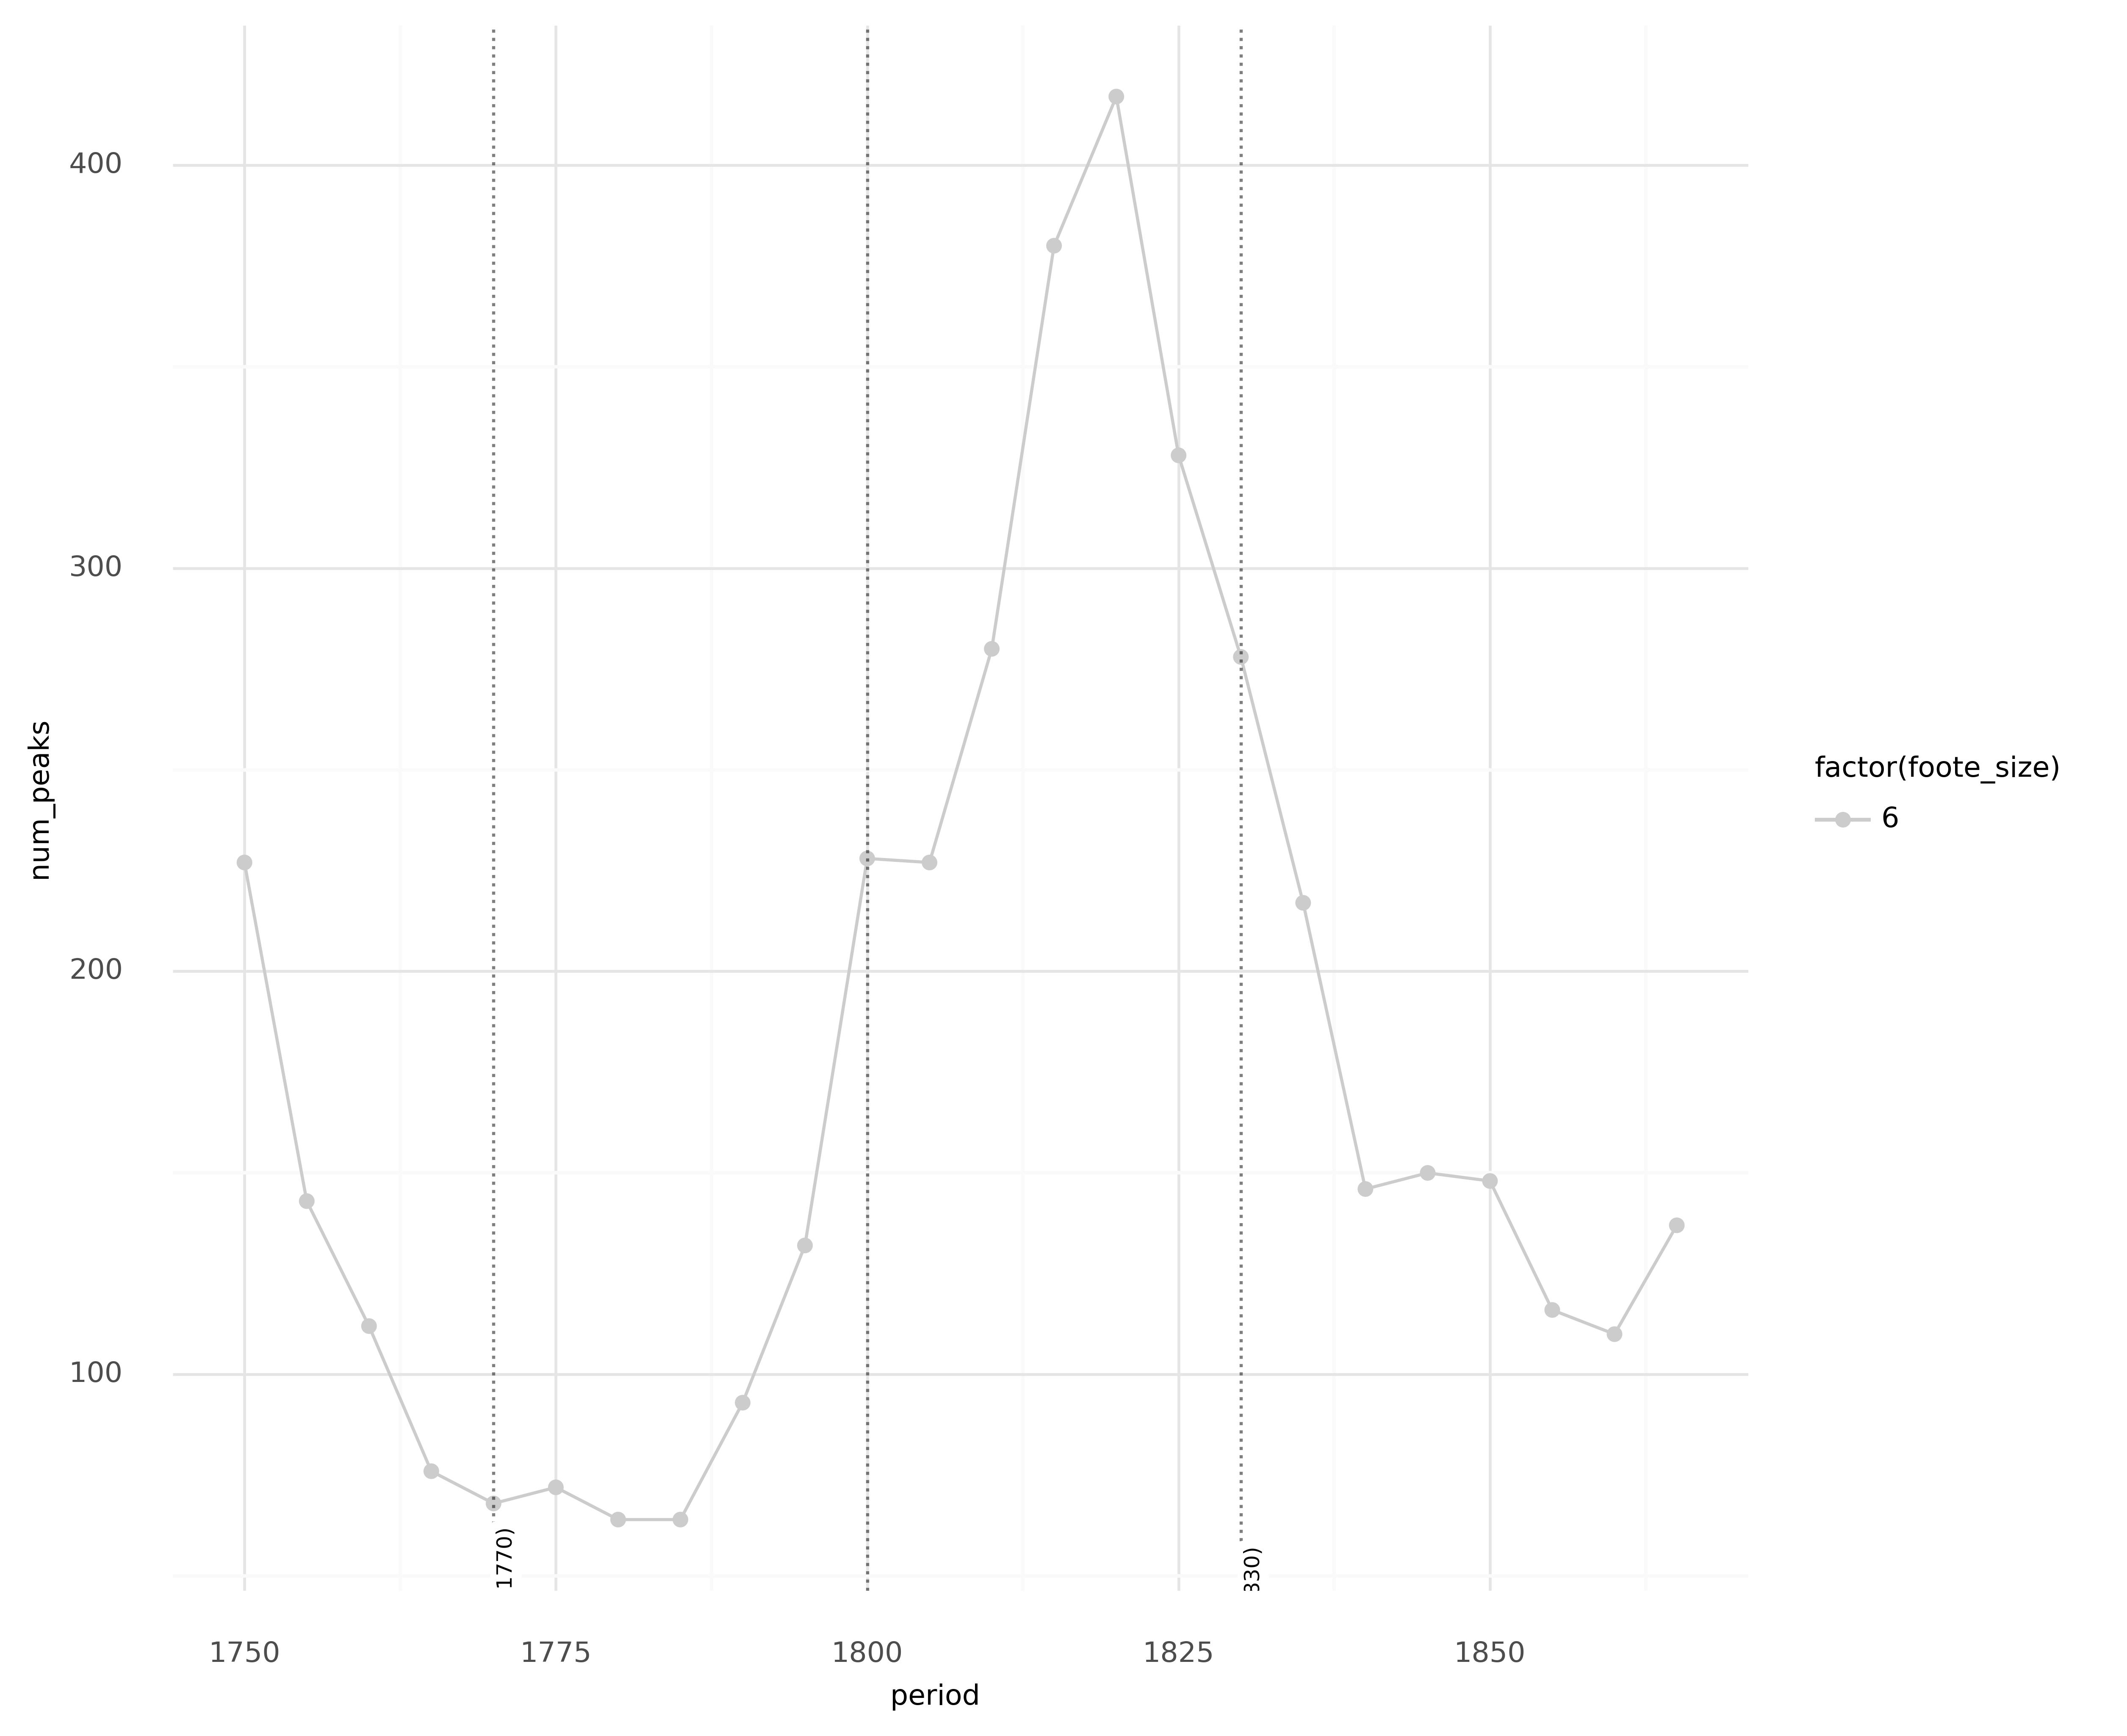

<ggplot: (8758902406393)>

In [20]:
plot_novelty_by_foote_size(rolling=1, p_peak=.01, min_peaks=1)#, words={'culture'})

In [21]:
# plot_novelty_by_foote_size(rolling=1, words={'potato'})

In [22]:
dfchangepoints=get_signif_novelty_scores(p_peak=.05, min_peaks=1).drop_duplicates('word',keep='first').sort_values('period')
dfchangepoints

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z,is_signif,word_num_peaks
41212,english,1750,2472.698413,0.01,1.0,2.047283,True,1
28734,creditors,1750,2266.891892,0.02,1.0,1.787479,True,1
123138,throne,1750,2034.603175,0.00,1.0,1.494245,True,1
43126,exalted,1750,2892.185008,0.00,1.0,2.576830,True,2
11275,belly,1750,2890.099010,0.00,1.0,2.574197,True,2
...,...,...,...,...,...,...,...,...
90858,phrase,1865,2418.918919,0.00,1.0,1.979394,True,1
17960,celebrity,1865,2432.380952,0.00,1.0,1.996388,True,3
854,accord,1865,2445.203252,0.00,1.0,2.012574,True,1
29066,critic,1865,2478.559177,0.00,1.0,2.054682,True,1


In [23]:
odfstr=pd.DataFrame([
    {'period':period, 'words':', '.join(grp.sort_values('foote_novelty_z',ascending=False).word)}
    for period,grp in sorted(dfchangepoints.groupby('period'))
])
printm(odfstr.to_markdown())

|    |   period | words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|---:|---------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 |     1750 | pamphlet, strand, yard, disorder, preface, temple, volumes, proceeds, lane, root, opposite, extremity, hearing, narrative, readers, rose, borders, daughters, vicious, chamber, sex, blue, nobility, gate, brown, ports, lodgings, buildings, distance, frost, wet, reader, exchange, wind, teeth, telling, plant, breath, endeavours, admirable, tooth, square, parallel, writer, symptoms, paragraph, patient, advertisement, wives, exalted, belly, space, climate, medicines, hours, meadows, appendix, translation, trouble, admiration, bulk, tears, fruit, compliments, supplement, neighbourhood, fever, ships, feet, judicious, jealousy, september, discovery, loft, age, complete, enjoyment, approbation, olive, water, low, table, indians, departure, humility, print, fields, sunday, cross, disgrace, fall, leagues, enquiry, impressions, hour, rock, point, sexes, brick, size, plants, middle, relish, situation, ridicule, fortune, annuity, companions, hole, green, wisdom, depth, critical, nobleman, heat, copper, gentle, gravel, pleasure, injuries, providence, planets, health, temper, weakness, nun, disposition, bounty, pains, office, inclination, preserving, tavern, resolutions, adjacent, drinking, appearances, fresh, food, humour, door, poet, gentleman, humane, misfortunes, pleasures, mere, bread, awake, english, irregular, neighbouring, ship, hints, apartment, degrees, friendship, substance, valuable, intentions, exempt, cent, refusal, prejudices, brothers, surface, perceived, spots, troubled, legs, politeness, genius, bird, specimen, kitchen, resentment, tenderness, mount, yellow, payment, cold, literature, wheel, gardens, fault, prophet, harbour, modesty, viscount, experiments, journey, sentiments, peculiar, nights, scarcity, cures, unnatural, capacity, perfect, adventures, roads, affections, creditors, territories, artifice, pernicious, knife, wheels, experience, large, rays, blind, obedience, husbands, controversy, fatal, ensuing, fortunes, monarch, consequences, cough, cork, eyes, arguments, wood, coast, barren, running, vices, revenge, reading, yards, reasons, tongue, generous, particles, rage, woods, tree, benefit, short, vapours, villages, curious, ears, artful, hills, ounces, river, deity, precedent, rocks, practice, asleep, inclinations, unable, university, centre, winds, young, candle, hops, reputation, coming, divine, spot, merit, public, throne, foundation, bowels, veil, stones, nose, ruins, towns, downs, infamy, exportation, homer, floor, eternal, remarkable, silence, liberty, rotten, bag, arrival, apparel, channel, verse, uneasiness, difficult, noblemen, fortifications, ammunition, dialogues, vinegar, reins, imaginable, strokes, impudence, curve, impudent, mam                                                                                                                                                                                                                                               |
|  1 |     1755 | golden, pretensions, edition, publication, acre, appetite, medicine, efficacy, infallible, remedies, citizen, volume, guineas, saturday, avail, corner, jam, nervous, ball, european, british, laudable, perusal, passion, eminent, neighbours, chaplain, additions, bottle, pleasant, effectual, languid, excellency, paper, dose, entertaining, faculties, pleasing, reverend, simple, leg, mien, night, rain, indifference, taste, generosity, indifferent, kingdom, conclusion, acts, expiration, repose, ridiculous, brain, tranquillity, concise, variation, girls, argument, boats, relative, gale, southern, governors, progress, violation, request, interval, melancholy, annuities, methods, gang, stomach, cutting, certainty, refined, ideas, easy, crew, companion, convinced, inveterate, grains, fertile, incredible, explanation, mod, quid, lap, conduit, respect, distant, apothecary, impression, clauses, barons, pensions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|  2 |     1760 | lively, animated, decay, dangerous, extensive, cure, danger, warmth, regulation, advice, horror, jury, dominions, princes, behaviour, confinement, dove, fortitude, adventure, lordship, notes, law, prejudice, lark, unfortunate, candid, empire, observation, manly, ode, continuation, degree, expedient, pocket, parting, inhabitants, eagle, envoy, amazing, gaol, animal, plan, convention, equity, hound, future, dispositions, amiable, july, periods, crimes, passage, sea, widow, mortality, illegal, lover, contemptible, suns, alley, secret, blooming, poem, grief, deceased, difficulty, brethren, verdant, esteem, cart, unacquainted, heavy, time, number, votes, snow, regiment, delicate, despair, interview, erudition, wretched, opportunities, merits, mediterranean, kindness, births, titles, nymph, vivacity, prudence, origin, attempts, liberties, worthy, obliging, cornet, preservation, bosom, superiors, doors, reverence, heats, levity, pits, danes, frontiers, wand, capacities, bribery, rounds                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|  3 |     1765 | sketch, saxon, retired, continent, footing, genteel, apology, chronicle, colonies, extended, disputes, sermons, solution, quarters, attempt, hero, propriety, period, doubts, camp, unanimous, misfortune, attachment, invitation, agreement, treasure, chair, favoured, radiant, counties, treaty, firmness, june, business, article, legislature, powerful, memoirs, individual, queries, village, declaration, opinion, retreat, witty, expensive, vanity, parties, innocent, benefits, loo, relation, approaches, dim, liquors, differences, parents, succession, essential, suspicion, marriage, criticism, march, accuracy, zeal, negotiation, battalions, dissertation, conversation, care, whimsical, drooping, creditor, concerted, gaudy, burgundy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|  4 |     1770 | plantations, acute, amendment, minute, motion, bleeding, meridian, flattering, carriage, mode, serene, clause, annals, load, lament, spirits, numerous, liable, intelligent, editor, concluding, bar, duration, american, correspondence, beloved, highness, trial, prison, males, improving, utility, plans, hearty, charge, session, laborious, german, vast, reward, kingdoms, drawing, magnitude, advantage, wounds, catalogue, detachment, additional, vegetable, settlements, payable, tot, affection, inquiry, advancement, peers, horse, navy, crying, conscious, justice, indebted, august, immense, evidence, dun, blade, replete, paradise, mutiny, fairs, convulsions, impropriety, flank                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|  5 |     1775 | holiness, blood, encouraging, fox, repentance, internal, flower, charges, political, grace, vote, salvation, proposition, faith, friendly, god, prayer, globe, mercy, letters, records, dates, avowed, wicked, foreigners, disease, manor, chief, deliverance, temptation, alive, holy, credit, bitter, malignant, criminal, operation, news, commencement, commendation, revolt, righteousness, righteous, prayers, adequate, bloody, appointment, flowers, blessing, flag, fife, proposed, object, conscience, offence, angels, soldier, monarchs, commissioners, covenant, merciful, early, goodness, saviour, iniquity, history, imitation, deliberation, prisoner, deportment, envious, tyrannical, inconveniences                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|  6 |     1780 | senses, warm, chancellor, reform, liberality, pledge, fable, rapid, praise, complaint, genuine, resources, giant, satire, habits, finances, debate, seamen, brink, follies, aldermen, moderation, glory, member, displays, accommodation, insolent, united, area, method, horizon, map, miserable, necessaries, commodity, axis, abuses, nation, fairy, tones, heights, presence, almighty, phi, tween, perpendicular, politician, enquiries, dignity, coasts, widows, affinity, bail, breeches, rainy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
|  7 |     1785 | scarce, feature, president, void, eve, promotion, exchequer, circle, calculation, baron, ends, reports, deserving, beneficial, mag, ratio, creator, discussion, obedient, humble, extension, subjects, modes, tremendous, charter, angle, latitude, code, city, dowager, pen, properties, faithful, beauteous, prosperity, supplies, block, prerogative, employments, ability, habitual, terrible, foot, paternal, essay, astronomy, diameter, correct, cloudy, heightened, americans, hoary, intricate, sources, negligence, regions, vim, creek, quarrels, sowing, perverted, dissipation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|  8 |     1790 | printer, term, journals, career, breed, loyal, gracious, tribute, negative, enlightened, pursuits, temperate, confident, memorable, bond, patronage, territory, hull, intrigue, elevated, duties, rare, revolution, exhibits, lustre, temporal, pious, gallantry, resignation, patience, husbandry, wit, medium, tolerable, decrees, ordinary, noon, china, decree, proportion, dying, independence, portion, provincial, exertion, discontent, sacrifices, agriculture, defendant, lawful, pecuniary, province, mathematical, eastern, loyalty, dwelling, canals, permission, dispatch, lights, thermometer, tyranny, energy, lottery, patriotism, plaintiff, clear, title, awful, fertility, riches, jail, servants, civility, flattery, promise, beings, sanction, comment, conviction, docs, fen, solidity, neutral, toot, recorder, efficacious, discernment, unerring, serpents                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|  9 |     1795 | relations, rural, discharge, circulation, dock, destruction, crops, communication, popular, attendant, abbe, dire, mass, quantity, opulent, machine, immortality, generation, capital, favourable, considerable, property, productive, decency, link, hesitation, conqueror, mayor, members, income, anxiety, contrast, swift, desirable, repository, scale, population, comfort, broker, domestic, classes, tory, enlarged, discourses, shape, doubt, translator, waste, comparison, respective, consul, determination, range, dead, unnecessary, fact, rulers, waters, tales, professor, romance, inferior, breasts, breeding, classical, indulgent, increasing, task, judgement, drawings, productions, claim, plane, manners, coffee, mercantile, safety, pears, extent, savages, skill, exports, turnips, odes, sweets, specie, voting, stanza, connections, avidity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| 10 |     1800 | demand, landlord, venerable, market, harvest, slow, exception, star, abundant, farmer, excess, tenant, dress, supply, cattle, resort, unfavourable, treatise, scanty, mould, previous, ass, magistrate, sculpture, stock, spanish, topics, reviewer, wealth, injury, investigation, commodities, foster, troubles, spring, wages, white, castle, devoted, lodge, medical, question, excited, topic, baker, abundance, comforts, authentic, october, expectation, money, tranquil, list, cultivation, chancery, anecdotes, exertions, engravings, ludicrous, profit, speculation, superfluous, mills, consumption, institution, descriptions, places, hare, voyages, improved, sum, rents, tracts, traits, dignified, publications, succeeding, representation, interesting, architecture, reformed, soul, ingenious, maker, coo, press, coach, museum, saint, seat, stall, discourse, statue, tempest, alarm, poems, attentions, vicinity, autumn, diminution, sun, subsistence, subject, surprise, rate, personage, december, victory, rows, figures, obvious, increased, protest, attentive, crowns, societies, production, surprised, moon, advance, heroic, defective, alarming, inquiries, warrant, tallow, extracts, prevailing, value, directions, central, failure, defect, claims, painters, regular, rest, unusual, rye, worship, explanatory, fiend, deficient, delay, sequel, intimate, academy, probable, successor, battles, respects, class, adoption, satisfactory, extract, light, superior, bears, traces, disposal, reviewers, flight, grey, difference, questions, chapels, physic, authority, facility, separate, nominal, heroine, consideration, consequence, distinguished, apprehensions, damp, mechanical, popish, excellence, instances, vid, copies, dreary, attention, collection, clock, complicated, mountain, despotic, alias, veracity, concurrence, wreath, fugitive, exceptions, visionary, veal, implicit, leases, mildness                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 11 |     1805 | flood, fat, hall, mall, memoir, clergyman, hint, sill, combat, grecian, saints, oppressed, biographical, plain, hip, sons, instruction, employment, lone, lace, pope, profusion, arc, labour, active, courts, trifling, tone, morrow, spirited, expectations, commercial, kinds, transactions, stocks, tragic, fashionable, protestants, temporary, recollection, lilt, painter, contradiction, actors, transfer, rich, intrinsic, grocer, model, letter, kid, catholic, surplus, goo, rewards, practicable, spectators, debt, ration, persuasion, dealer, charitable, vet, partial, fated, creed, antiquarian, education, ruinous, researches, clergy, striking, hats, instructions, superb, report, ornaments, powers, bed, conversion, conjecture, encounter, arduous, fan, condition, characters, forts, hilt, ills, copy, narrow, grandeur, mud, occupation, scholar, tons, spacious, recourse, poll, enclosed, velvet, distinction, dissenters, useless, maiden, piercing, judges, waist, invasion, unexpected, allusion, bro, statutes, ting, accomplishment, illustrious, instance, dill, vapour, tide, view, chaste, speeches, shadow, story, contract, clergymen, counter, capitals, cons, impossible, step, wick, epigram, atrocious, reliance, tics, intro, animation, sullen, bey, stanzas, ado, refutation, aspiring, epithets                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 12 |     1810 | flock, fir, distress, fitting, authorities, youths, tight, heart, bark, severity, indignant, aid, ilk, era, rites, elf, vile, vital, punishment, boon, store, confusion, peculiarity, subsequent, expenditure, falsehood, fraught, astonishing, splendour, catholics, sacred, police, dutch, sober, individuals, reference, setting, heathen, victim, pail, taxes, anxious, empress, parishes, doctrines, sanguine, rill, wretchedness, charity, kit, taxation, aft, prodigious, urge, church, convenient, local, answer, chance, strangers, tricks, bible, messenger, wits, tenets, facts, false, ire, ashes, rat, pupils, prospect, persecution, ion, stat, advocate, superstition, mysterious, misery, talent, chairman, mist, christianity, infant, arrangements, cot, authenticity, school, ling, devout, fort, dam, stations, omission, lingering, passing, conformity, distinct, offences, miseries, opponents, ions, clothing, conversant, annual, bargain, dialogue, ices, groans, hose, sin, stature, faction, calamity, doctrine, respectable, precepts, shop, high, tyrant, brilliancy, disputed, planet, habit, shelter, signal, temperature, mental, pretence, haughty, injustice, evils, pathetic, needless, lake, magistrates, astonished, oat, promising, originality, religion, portraits, suitable, schools, fate, feelings, gifts, establishment, brutal, traveller, lessons, scholars, pity, flame, englishman, hospitality, conic, modem, standing, worldly, courier, hoard, shame, procession, atonement, feeling, disappointment, arrest, strange, interference, martyr, decent, series, anniversary, dungeon, travellers, christians, displeasure, latin, sooth, belief, sordid, stable, solicitude, policy, watt, horizontal, sleep, botanical, deception, chart, bosoms, scourge, adherence, fallacy, disapprobation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 13 |     1815 | foul, main, fleet, labourer, piece, lip, farce, tinder, drama, guide, comedy, eternity, cries, performance, performances, wig, varying, engagement, tic, theatre, mixture, entertainment, delightful, riot, comic, beasts, favourite, improper, sheep, ill, medal, nut, labourers, patriot, discipline, dance, tragedy, tilt, madness, splendid, gas, mat, lien, tine, cabinet, stage, solitude, alleged, polite, thief, absence, gun, cruelty, fashion, offensive, barrier, dull, furious, preparations, oppression, district, cave, dried, institutions, opera, hard, losses, suffering, sufferings, charms, persian, portrait, gratification, magnificent, joys, ice, material, balance, emperor, eves, legislation, scotch, appearance, relict, vigorous, bold, marine, patron, big, lids, abuse, pole, tow, community, luck, popularity, fool, fools, dome, portions, weapon, precision, heaven, tent, maritime, loss, warning, hook, expression, abbot, project, fragment, poverty, foolish, french, rocky, physician, scorn, summit, transient, trite, painting, baptism, distribution, sensibility, bard, beauties, antiquity, newspapers, lovers, chivalry, wanton, elegant, statement, tribe, expedition, formation, efforts, pathos, physical, ceremonies, murderer, risk, songs, prisoners, lull, magazines, liter, grateful, audience, delusion, fears, lice, secrets, plains, chains, cottage, stream, sympathy, vegetables, bands, eel, legislative, simplicity, pistol, dramatic, admiral, pillow, revenue, astonishment, assault, military, adieu, masters, chancel, affliction, jest, qualifications, huge, repetition, moat, extraordinary, ally, impious, visiting, lesson, cruel, conversations, earth, crowd, knot, skilful, rhyme, stages, mad, navigation, acquaintance, propagation, reformers, interest, arrangement, benevolence, testimony, lure, idol, absurdities, butt, monopoly, support, apparatus, desolation, russian, intrigues, mountains, realms, terror, jewels, villa, pressing, perfection, utter, cases, dread, ease, mantle, names, rapidity, inherent, dreams, solid, figure, pregnant, peep, perilous, romantic, treachery, thirst, reformation, texture, ascending, tithe, diary, metallic, dawn, momentary, genus, sentimental, aware, susceptible, rise, wise, shores, pun, glad, prelates, captivity, herds, reality, science, clearness, valley, limo, hostility, clover, subservient, shops, span, sanguinary, souls, mansions, palpable, abridged, operating, pang                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| 14 |     1820 | execution, cat, slavery, subdued, kindred, bell, devil, designs, lad, sword, entertainments, post, retirement, rod, obscurity, maid, periodical, awe, force, fun, applause, theatres, successful, meal, variations, plea, arm, desperate, review, companies, deadly, hive, boxes, exterior, norman, abolition, madras, process, grove, delighted, wounded, britons, theatrical, proofs, posts, cow, song, arid, gent, varied, gains, frightful, voice, sustained, imposing, choice, prelate, illness, ripe, bull, toil, offspring, remembrance, comparative, agricultural, control, slaves, gratifying, delicacy, vivid, acceptable, bards, estimation, february, corpse, fierce, ore, monsieur, intense, barley, scenes, spare, moss, strike, ivy, harsh, sip, joint, experiment, gem, steps, nations, inland, hen, ballad, gin, feast, colouring, loving, lint, ear, path, safe, merry, fiery, wickedness, roar, cheeks, break, armed, park, patrons, consecrated, pause, design, jet, honours, magnificence, clerical, gallery, nobles, solitary, fur, war, disagreeable, exquisite, senior, chorus, sentences, ornament, penalty, ink, steward, combinations, building, darling, forte, attack, enemy, sailor, barbarous, security, pig, car, black, sensations, wrath, invaluable, ecclesiastical, hack, amusing, childhood, superstitious, hopes, sweetness, officer, strain, tombs, doom, countenance, bravery, delight, supporters, ocean, lofty, blast, attendants, swan, fixed, hostile, drunk, romans, exclusive, sonnets, lion, spear, luxury, calling, deserted, lawn, battle, wars, hopeless, protection, ash, mortification, attacks, reflections, glories, whip, gray, airy, storms, folly, burning, pasture, dart, cloak, honest, heated, helpless, consequent, accident, graces, commons, veteran, servile, archbishop, perception, profound, restoration, rush, glorious, elaborate, ide, curiosity, ordinances, deeds, poetical, understanding, female, dismal, vows, machinery, sceptre, rugged, brook, joke, expressive, cur, cottages, fear, captive, descending, bondage, careless, supper, ark, turkish, gloom, sot, deserts, involved, turning, priests, contemporaries, greek, finger, historians, guilt, farewell, decayed, impatience, stiff, orders, lions, charming, tired, mob, cliff, yields, conspicuous, fanciful, ancient, passengers, timid, adversary, waves, ger, occurrence, indignation, uniformity, frantic, substitute, aspect, beautiful, knee, monuments, deep, estimated, breakfast, rags, event, bot, lust, government, laity, stem, roofs, universities, angry, shot, graceful, wine, face, power, inability, unwilling, dream, gleam, possession, relics, unintelligible, glaring, precise, conquest, amounts, emigrants, proof, cheerful, lips, hands, unnoticed, pavement, sublimity, bride, walls, planters, crowds, parental, doubtful, skins, jaws, rout, majestic, azure, selfish, ferocious, cruelties, bitterness, sitting, vicissitudes, scaffold, advert, rudiments, mediocrity, licentiousness |
| 15 |     1825 | intelligence, regent, price, flint, site, bit, crop, witness, grand, cup, proportions, fellow, season, comfortable, interior, circuit, speed, stranger, street, culture, doctor, farm, gravity, rude, contributions, grass, message, wheat, pardon, bookseller, constable, cheek, host, hail, laughter, moving, surgeon, uniform, horses, harp, feeding, rolls, mark, heir, official, cost, beggar, ton, healthy, gentlemen, marriages, potatoes, mate, abode, damage, lock, conference, dissolution, evenings, triumphant, magazine, creature, bow, infidelity, hungry, endless, continental, fires, growing, average, salmon, sweep, bucks, thinking, bare, coat, enterprise, haste, refuge, livery, tidings, bid, dancing, cotton, murmur, brute, heels, slaughter, familiar, charm, structure, politics, banker, summons, mouth, hill, warrior, attraction, speaker, rough, instant, battery, stern, clean, sagacity, agony, vein, coil, brandy, herd, instructive, meritorious, fabric, guest, esteemed, youthful, profitable, memory, daily, councils, virtue, char, influences, mystery, weeds, asiatic, meek, candidate, content, land, degradation, brave, philosophic, fence, division, wrongs, red, defiance, pear, towers, intolerable, fruitful, activity, vent, noise, oak, epoch, morality, eye, rem, lieutenant, poetic, hand, impatient, observer, exile, turf, handkerchief, comprehensive, terrific, deed, odd, suit, moral, embassy, temptations, weeping, loose, concern, maids, heads, kiss, construction, library, anger, beauty, wile, shoe, victims, craft, garb, box, destination, englishmen, width, variety, imagination, round, rind, crime, noisy, open, marvellous, centuries, blaze, identity, exultation, fishes, clothes, tides, conquerors, editors, cap, visitors, release, episcopal, rig, streams, loans, sides, stuff, synod, torch, countenances, brim, compilation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 16 |     1830 | cloth, sport, linen, loth, cheap, elements, penny, incumbent, leather, quality, fearful, rains, glance, sway, pace, seed, miscellany, pub, social, grain, educated, weather, polished, correspondents, game, hounds, blank, paths, busy, scottish, urban, farmers, vegetation, summer, villain, dry, nest, seasons, silk, squire, hunter, couch, pool, breast, moments, brow, strife, shields, butcher, nice, tradition, foes, flies, shillings, emancipation, straw, vale, silver, minutes, cell, seeds, peaceful, contemporary, occasional, steel, occurrences, winter, paint, ride, potent, floating, pack, dogs, foe, coarse, dictionary, explanations, wretch, transparent, booksellers, caps, stroke, careful, hearted, scent, growth, chemistry, dog, gold, vine, correspondent, mile, coats, disgust, trout, feudal, psalm, universal, emblem, indulgence, cellar, breeze, manure, incidents, anguish, glittering, revolutionary, performer, demon, importation, naked, laurels, attire, sigh, mortals, tender, devoid, scarlet, payments, anglo, barber, couple, pride, peas, tops, group, length, glare, nurse, sudden, wave, barrel, guests, turkey, irresistible, data, rolling, shoes, banner, writings, violent, arms, burial, fiction, surrounding, bowl, chin, highlands, infidel, landing, stories, skies, trees, problem, whisper, professors, visitation, stockings, basket, restless, indication, welfare, darkness, ruler, subtle, fishing, sorts, sheets, endowments, sty, canopy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| 17 |     1835 | organ, band, element, evidences, lines, score, edge, markets, border, welsh, hay, position, messiah, jar, merchant, timber, type, performers, agitation, outline, foliage, league, fare, bank, tiny, exciting, marks, majesty, association, hut, derby, tenor, shrine, vocal, beard, music, oriental, theme, transport, dust, virgin, musical, closing, sire, tune, manufacture, ham, pockets, bench, brass, pattern, meetings, nonsense, premium, beam, wing, prevalent, smile, vehicle, leader, sales, gems, carpenter, seconds, players, wax, sphere, embroidered, coloured, bust, oily, incident, row, needful, civilization, broad, contrived, views, ring, wells, pounds, meeting, happiness, italian, tomb, walking, maintenance, court, collar, beams, transition, abstract, purity, pine, adverse, gothic, groves, forms, avid, folds, external, inscriptions, stray, signature, rectory, theories, scenery, mutton, filial, horrible, virtues, silent, highland, race, celestial, clay, gaze, verge, treasures, inhabitant, goose, fees, visitor, rope, doctors, discoveries, lonely, secretaries, sorrow, shield, reigning, cloud, monastery, shoulder, premiums, chill, sou, friars, shower, legion, vehemence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 18 |     1840 | assurance, sad, races, trials, boards, wee, outlines, destitute, deaths, tint, chinese, bees, organization, plate, admission, colour, teaching, cam, company, energetic, worm, director, noble, inn, seats, wad, locks, absurdity, compositions, oaths, mirror, models, moderate, imaginary, tints, residence, fashions, pillars, toe, theology, notorious, conditions, dot, house, hem, society, union, unseen, intercourse, travel, honourable, proper, appeals, indications, rubbish, formal, wire, progressive, pots, luminous, necessities, uneasy, principles, orange, array, galleries, conclusions, morbid, assurances, earthly, grave, chronology, belle, electric, functions, throng, form, curse, boots, gospels, sky, sim, windows, adventurers, trap, groom, afraid, impossibility, sundays, boot, coldness, rainbow                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 19 |     1845 | receipt, special, stamp, gilt, types, profits, columns, file, hooks, calf, countries, agents, aim, preachers, standard, engine, overture, prophetic, contribution, garden, mission, current, inspiration, woollen, eclipse, tribes, insertion, vague, missionaries, tier, tin, prices, binding, train, keen, ounce, circular, dreadful, tear, scandal, hair, monster, fame, principal, liquid, interpreter, forehead, needle, methodist, italians, humanity, ace, mischief, bead, bags, positive, successive, teachers, shares, tendency, pier, deposit, inevitable, ready, demonstration, ant, currency, opinions, deluge, disinterested, ivory, belt, quiet, zealous, track, ruling, actual, judgment, documents, oppressive, bronze, fulness, ages, ticket, necessity, shining, sepulchre, snowy, requisite, ladyship, frightened, mankind, universe, hymn, flour, longing, cabin, unity, compact, disturbance, stately, irons, driver, chances, garment, consummate, inviting, carpet, spy, shapes, resolute, filthy, phantom                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 20 |     1850 | station, application, palace, lads, manager, exhibition, conception, mix, furnishing, genial, acceptance, concerns, lore, banquet, cuts, burden, arches, worlds, wool, treatment, absolute, dick, lamps, presentation, gathering, dealers, libraries, corn, likeness, mid, weapons, glee, hell, scriptural, gross, robin, beau, fancy, anti, destiny, manufacturers, relief, talents, fondness, consciousness, pupil, hazard, meat, action, attendance, integrity, renown, eligible, miracle, equivalent, total, sorrows, cool, rule, vow, college, ultimate, powder, biography, whigs, card, exhibitions, conveyance, revelation, collections, product, justification, aristocracy, household, species, commentary, shoulders, colleges, manhood, arbitrary, fervour, papal, malady, boys, learning, metaphysical, stain, destructive, quest, skull, sly, mess, vicarage, elastic, spurious, foam, commissioner, sinful, rides                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 21 |     1855 | choir, oil, curate, dean, engagements, sign, competition, decline, voices, sugar, forces, leisure, owner, accidents, remedy, lam, halls, lawyer, pound, rite, secular, applications, connexion, chi, pie, desirous, egg, peak, pure, meals, imitations, acquisition, dish, tall, sis, department, festival, fundamental, penal, advertisements, goods, surviving, pencil, benevolent, baths, indian, statesman, desired, machines, definition, inter, possibility, civil, tongues, descriptive, profession, joy, papa, attainments, clever, dense, joyous, homely, shirt, diction, freeman, toast, cream, drunken, caves, steeple, cement, claret                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| 22 |     1860 | extra, stake, crown, hat, pet, studies, tile, attitude, dark, tie, tour, communications, smart, liking, tunes, eggs, vicar, tutor, traffic, nit, halt, cards, seal, horrid, sabbath, scientific, author, chat, hotel, super, tit, exercises, excursion, awl, memorial, preferred, leaf, unhappy, implements, chain, attainment, prolonged, jew, inventor, boat, inadequate, fair, milk, pa, lives, fighting, pleading, serviceable, measure, ugly, record, minority, calendar, edges, venetian, pens, psalms, jewel, priory, pills, conceptions, lilies, meagre, chimney, dances, atlas, cradle, explosion, crack, inquiring, luxuriant, errand, apples, purchasers, waking, perfume, joints, tempting, watering                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| 23 |     1865 | flat, compass, concert, major, royalty, rendering, key, movements, trumpet, organs, revival, sole, minor, bengal, vice, particulars, gazette, late, interpretation, voluntary, pitch, lack, eldest, monk, hospital, harmony, famine, flute, caution, patent, limited, gaiety, situations, examination, aged, road, liberal, reserve, agency, bars, pipes, foremost, pieces, string, instruments, pall, motive, dominion, prime, passages, alternative, artists, transaction, amused, baronet, firm, offices, height, bath, references, service, movement, player, trifle, premises, deliberate, multitude, nerve, boiling, hymns, fee, rector, publisher, assistant, access, cannon, efficient, sketches, congregation, texts, proposals, keys, octavo, junction, professional, jolly, puzzled, instrument, double, engines, agent, nod, masterly, critic, revised, accord, celebrity, phrase, retail, device, medals, services, inspection, board, salt, breadth, salary, drum, arab, peasant, celebration, pro, bacon, note, jealous, operas, brightness, scripture, parts, devices, lecture, melody, metal, sincerity, canon, hardy, refinement, treasurer, romances, colonel, hospitals, channels, affectionate, estimates, scales, pronounced, overtures, mythology, phrases, shades, hammer, elementary, bachelor, democratic, protector, pilgrim, violet, victories, tradesmen, lyric, exposition, heiress, contracts, purchaser, melodious, rounded, warehouse, triple, sickly, procedure, spray, tenure, currents, bundle, fitness, threads                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |

## Plotting individual words

In [1]:
def get_plot_novelty_figdf(novdf):
    figdf=novdf.sample(frac=1)
    ywl=[
        f'{x} years'
        for x in figdf['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf['year_window']=pd.Categorical(ywl, categories=ywll)
    figdf['glen']=1
    figdf['is_signif']=pd.Categorical(
        [bool(x<0.05) for x in figdf.p_peak],
        categories=[True,False]
    )
    
    figdf = pd.concat(
        grp.assign(foote_novelty_z=grp.foote_novelty.apply(lambda x: (x-grp.foote_novelty.mean())/grp.foote_novelty.std()))
        for i,grp in figdf.groupby('foote_size')
    )
    return figdf.dropna().sort_values(['year_window','period'])


# @interact
def plot_novelty(
        words=None,
        novdf=None,
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=None,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=False,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        by_word=False
        ):

    figwords=set(words) if words else {'allwords'}
    if novdf is None:
        if words is None:
            print('neither words nor novdf')
            return
        
        novdf = get_novelty(words,min_foote_size=min_foote_size,max_foote_size=max_foote_size)
        if not by_word: words=None
        print(f'Computed novelty df of shape {novdf.shape}')
#         display(novdf)
        
#     figdf=get_plot_novelty_figdf(novdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}'))
    figdf=get_plot_novelty_figdf(novdf)
    if not len(figdf): return
    if max_p_peak: figdf=figdf[figdf.p_peak<max_p_peak]
    
    
    figdf=figdf.sort_values('period')
    if showdata: display(figdf)
    fig=start_fig(
        figdf,
        x='period',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))
    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
    wkey=''
    if words: wkey=words.replace(' ','') if type(words)==str else '-'.join(words)
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)

    if combine:
        yymin1=figdf.period.min()
        yymax1=figdf.period.max()
        figdm=plot_historical_semantic_distance_matrix(words=figwords,ymin=xlim0,ymax=xlim1)
        ofig=combine_plots(figdm,fig,ofn=ofnfn)
    else:
        ofig=fig
        if save: ofig.save(ofnfn)
    if save: upfig(ofnfn)
    return ofig

In [2]:
def plot_novelty_words(words,**kwargs):
    words=[w.strip() for w in words.split(',')] if type(words)==str else list(words)
    inpd=dict(
        y='foote_novelty_z',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=False,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=5,
        max_foote_size=5,
        showdata=False,
        nudge_x=2,
        logy=False,
        ylim0=0,
        ylim1=10,
        xlim0=1745,
        xlim1=1870,
        rolling=2,
        ymin=-1.5,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=0.25,
        save=False,
        by_word=True
    )
    return plot_novelty(**{**inpd, **kwargs})


In [3]:
plot_novelty_words('station,culture,slave,demand,value,honour,revolution',save=True)
# plot_novelty_words('station')

NameError: name 'get_novelty' is not defined